# Improving WW3 Outputs with Machine Learning

## Data

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id="1fHsQECCZCBUwcljb1l7iUSWvwZqSlY1e",
                                    dest_path="./wave_data.csv")

In [2]:
import os
import platform

import datetime

import argparse

import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (Dense, Conv2D, Dropout,
                                     MaxPooling2D, Flatten, Input)
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session

# from tensorflow_addons import metrics as tfam
from tensorflow.keras import metrics as tfm

from joblib import dump

## Model

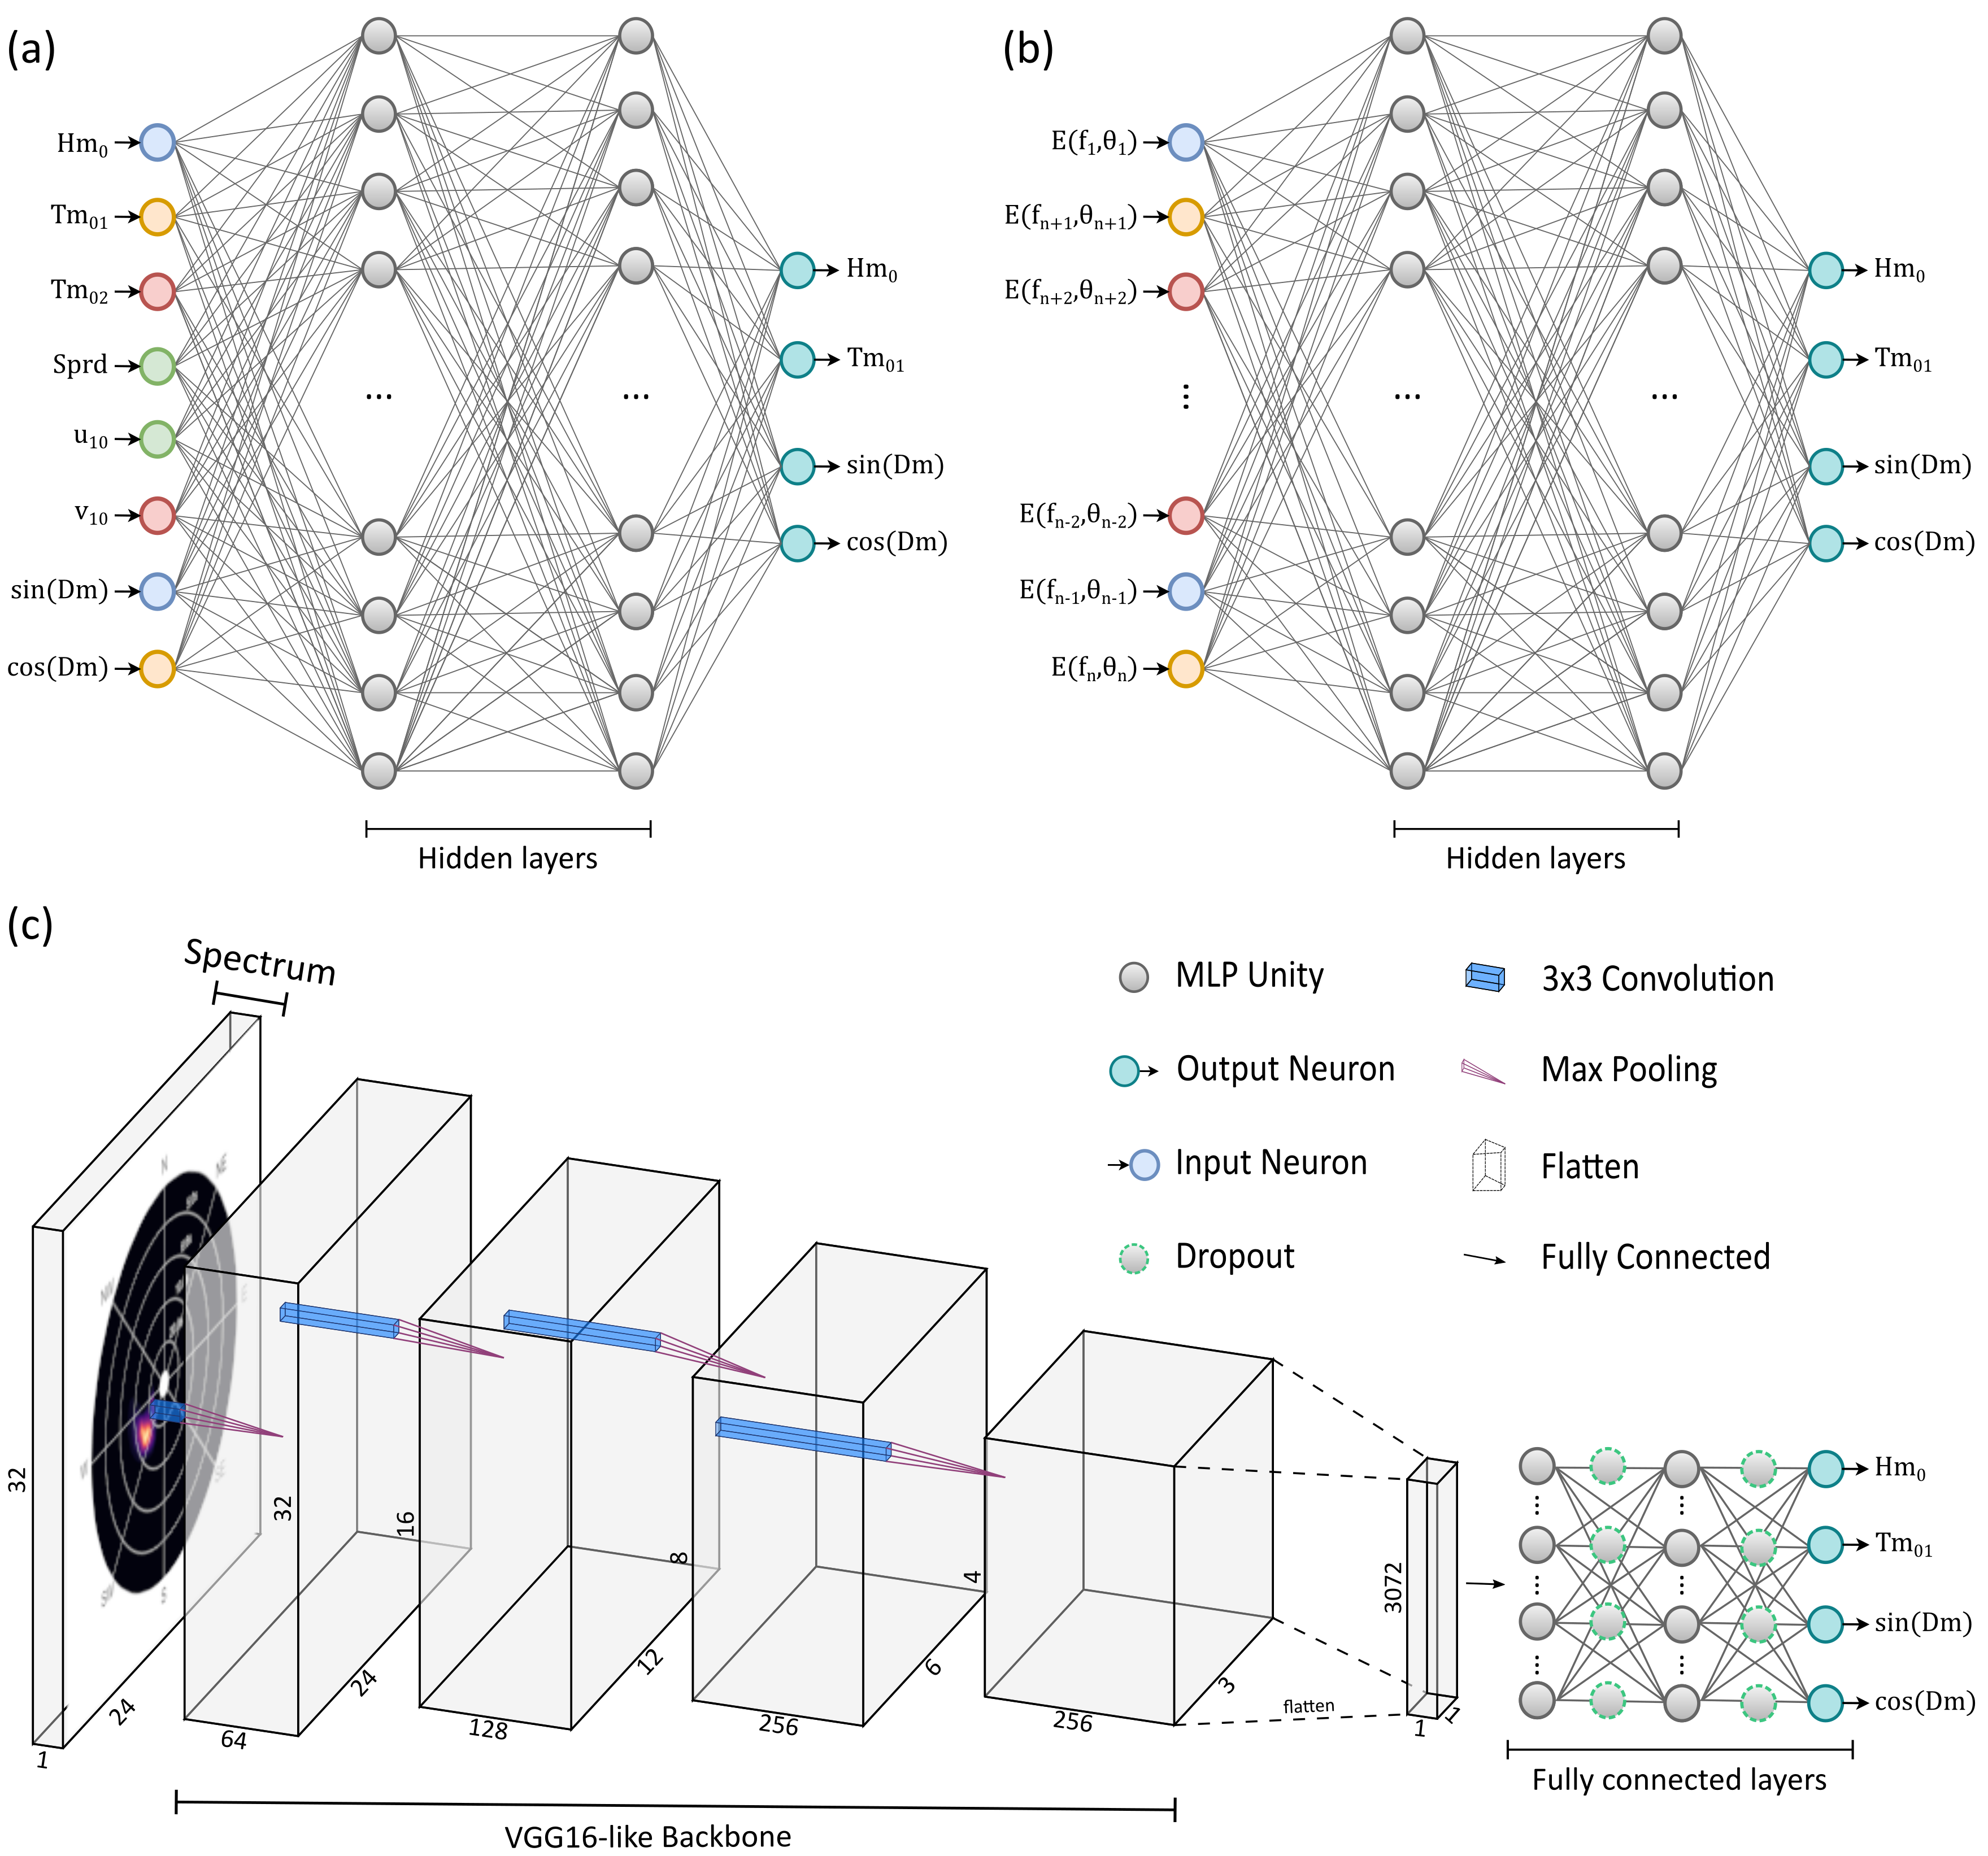

In [3]:
#@title Hyperparameters
DATA="wave_data.csv" #@param {type:"string"}
RANDOM_STATE=42 #@param {type:"number"}
TEST_SIZE=0.3 #@param {type:"number"}
LEARNING_RATE=0.0001 #@param {type:"number"}
EPOCHS=128 #@param {type:"number"}
BATCH_SIZE=256 #@param {type:"number"}
DROPOUT=0.25 #@param {type:"number"}
HEIGHT=32 #@param {type:"number"}
WIDTH=24 #@param {type:"number"}
TYPE = "cnn_spectral" #@param ["cnn_spectral", "mlp_spectral", "mlp_parametric"]
NAME="CNN_SPC_HTD" #@param {type:"string"}
LAYERS=2 #@param {type:"number"}
NEURONS=512 #@param {type:"number"}
LOGDIR = "logs" #@param {type:"string"}
STRATIFY = True #@param {type:"boolean"}

### Multi-layer Perceptron Definition

In [4]:
def MLP(shape, n_layers=2, n_neurons=512, dropout=0.25, name="my_model"):
    """Simple fully-connected MLP."""

    layers = []
    # add the input layer
    layers.append(Dense(n_neurons, activation="relu",
                        kernel_initializer="glorot_normal",
                        input_shape=shape))
    layers.append(Dropout(dropout))

    # add the other layers
    for _ in range(n_layers - 1):
        layers.append(Dense(n_neurons, activation="relu"))
        layers.append(Dropout(dropout))

    # add the output layer
    layers.append(Dense(4, activation="tanh"))

    # build the model
    model = Sequential(layers, name=name)

    return model

### Convolutional Neural Network Definition

In [5]:
def CNN(shape=(32, 24, 1), dropout=0.25, name="my_model"):
    """Simple CNN model."""

    # define model input
    visible = Input(shape=shape)
    # add vgg module
    layer = vgg_block(visible, 64, 2)
    # add vgg module
    layer = vgg_block(layer, 128, 2)
    # add vgg module
    layer = vgg_block(layer, 256, 4)

    # flatten
    flat = Flatten()(layer)
    fcn1 = Dense(1024)(flat)
    drop = Dropout(dropout)(fcn1)
    fcn2 = Dense(1024)(drop)
    drop = Dropout(dropout)(fcn2)
    fcn3 = Dense(4)(drop)

    # create model
    model = Model(inputs=visible, outputs=fcn3, name=name)

    return model


def vgg_block(layer_in, n_filters, n_conv):
    """standard VGG block."""
    # add convolutional layers
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3, 3), padding='same',
                          activation='relu')(layer_in)
    # add max pooling layer
    layer_in = MaxPooling2D((2, 2), strides=(2, 2))(layer_in)
    layer_in = Dropout(0.1)(layer_in)  # DROPOUT?
    return layer_in

### Functions

In [6]:
def summarize_predictions(data, model, scaler, X, ytrue, subset, idx):
    """Apply the model and return a dataframe with predictions."""

    yhat = np.squeeze(model.predict(X))

    # convert sin,cos back to radians and degrees
    y_pred_rescaled = np.arctan2(yhat[:, 0], yhat[:, 1])
    y_true_rescaled = np.arctan2(ytrue[:, 0], ytrue[:, 1])
    dm_pred_rescaled = np.rad2deg(y_pred_rescaled + np.pi)
    dm_true_rescaled = np.rad2deg(y_true_rescaled + np.pi)

    # rescale Hs and TP
    hs_tp_pred_rescaled = scaler.inverse_transform(yhat[:, 2:])
    hs_tp_true_rescaled = scaler.inverse_transform(ytrue[:, 2:])
    hs_pred_rescaled = hs_tp_pred_rescaled[:, 0]
    tp_pred_rescaled = hs_tp_pred_rescaled[:, 1]
    hs_true_rescaled = hs_tp_true_rescaled[:, 0]
    tp_true_rescaled = hs_tp_true_rescaled[:, 1]

    # build a dataframe
    cols = ["Hs_buoy", "Hs_prediction",
            "Tp_buoy", "Tp_prediction",
            "Dm_buoy", "Dm_prediction"]
    X = np.vstack([hs_true_rescaled, hs_pred_rescaled,
                   tp_true_rescaled, tp_pred_rescaled,
                   dm_true_rescaled, dm_pred_rescaled]).T
    df = pd.DataFrame(X, columns=cols)
    df["subset"] = subset

    # add extra varibles for later plots
    df.index = data.iloc[idx].index.values
    df.index.name = "time"
    df["location"] = data.iloc[idx]["ID"].values
    df["Hs_wavewatch"] = data.iloc[idx]["Hm0_mod"]
    df["Tp_wavewatch"] = data.iloc[idx]["Tm1_mod"]
    df["Dm_wavewatch"] = data.iloc[idx]["Dm_mod"]

    return df

## Main program

In [ ]:
# --- parameters ---
data = DATA
model_name = NAME
spc_size = (HEIGHT, WIDTH)
batch_size = BATCH_SIZE
random_seed = RANDOM_STATE
epochs = EPOCHS
test_size = TEST_SIZE
learning_rate = LEARNING_RATE
stratify = STRATIFY
dropout = DROPOUT
logs = LOGDIR
nlayers = LAYERS
nneurons = NEURONS
model_type = TYPE

# --- Tensorboard ---

date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if platform.system().lower() == "windows":
    logdir = logs + "\\" + model_name + "\\" + date
else:
    logdir = logs + "/" + model_name + "/" + date
if not os.path.isdir(logdir):
    os.makedirs(logdir, exist_ok=True)

tensorboard = callbacks.TensorBoard(log_dir=logdir,
                                    histogram_freq=1,
                                    profile_batch=1)

# --- Outputs ---
if platform.system().lower() == "windows":
    scaler_out = logdir + "\\" + "scaler.dat"
    checkpoint_path = logdir + "\\" + "best_epoch.h5"
    last_epoch = logdir + "\\" + "last_epoch.h5"
    history_path = logdir + "\\" + "history.csv"
    data_out = logdir + "\\" + "predictions.csv"
else:
    scaler_out = logdir + "/" + "scaler.dat"
    checkpoint_path = logdir + "/" + "best_epoch.h5"
    last_epoch = logdir + "/" + "last_epoch.h5"
    history_path = logdir + "/" + "history.csv"
    data_out = logdir + "/" + "predictions.csv"

checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        save_best_only=True,
                                        save_weights_only=False,
                                        monitor='val_loss',
                                        mode="min",
                                        verbose=1)

# --- Pre-process data ---

# read the data from file
inp = pd.read_csv(data, delimiter=",", index_col='Time_UTC')
df = inp.iloc[:, -25:]  # these are the scalar variables

# get the X data based on model type
if model_type.lower() == "mlp_parametric":
    train_features = ["Hm0_mod", "Tm1_mod", "Tm2_mod", "Spr_mod",
                        "U_mod", "V_mod", "Dm_mod_sinx", "Dm_mod_cosx"]

else:
    ds = inp.iloc[:, 1:-25]  # this is the spectral training data

# convert Dm_obs and Dm_mod to radians so that it is a continous
# variable between -pi and pi

df["Dm_mod_rad"] = np.deg2rad(df["Dm_mod"]) - np.pi
df["Dm_obs_rad"] = np.deg2rad(df["Dm_obs"]) - np.pi

# compute the sin and cos so it's between -1 and 1
df["Dm_mod_sinx"] = np.sin(df["Dm_mod_rad"])
df["Dm_mod_cosx"] = np.cos(df["Dm_mod_rad"])
df["Dm_obs_sinx"] = np.sin(df["Dm_obs_rad"])
df["Dm_obs_cosx"] = np.cos(df["Dm_obs_rad"])

# prepare the training, testing and validation datasets
if model_type == "mlp_parametric":
    X = df[train_features].values
else:
    X = ds.values

# prepare output array - Buoy data
# note that the value of Hs and Tp are normalized between -1 and 1 here
hs_tp_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(df[["Hm0_obs",
                                                            "Tm1_obs"]])
hs_tp = hs_tp_scaler.transform(df[["Hm0_obs", "Tm1_obs"]])

# target data that we are trying to predict
y = np.vstack([df["Dm_obs_sinx"].values,
                df["Dm_obs_cosx"].values,
                hs_tp[:, 0],
                hs_tp[:, 1]]).T

# Use the location names to split the dataset according to their
# distribution.This avoid one location being left out the training
if stratify:
    df["labels"] = pd.factorize(df["ID"])[0].astype(np.uint16)
    labels = df["labels"].values
else:
    labels = np.ones(y.shape)

# get dates
indexes = np.arange(0, len(df), 1)

# split train/test
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indexes, test_size=test_size, stratify=labels,
    random_state=random_seed, shuffle=None)

# split train/val
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train, y_train, idx_train, test_size=test_size,
    random_state=random_seed, shuffle=True)

print("\nThere are {} training samples, "
        "{} validation samples, and {} testing samples".format(
            X_train.shape[0], X_val.shape[0], X_test.shape[0]))

# scale data 0-1 interval
xscaler = MinMaxScaler().fit(X_train)
X_train = xscaler.transform(X_train)
X_test = xscaler.transform(X_test)
X_val = xscaler.transform(X_val)
# X_all = xscaler.transform(X)
# save the scaler for later usage
dump(xscaler, scaler_out)

# --- Model ---

# start by clearing the section
clear_session()

# reshape the data. This a very important step.
# we need to reshape the data so that it is the the shape
# that tensorflow likes.

if model_type.lower() == "cnn_spectral":

    # reshape for the CNN
    X_train = X_train.reshape(X_train.shape[0],
                                spc_size[0], spc_size[1], 1)
    X_test = X_test.reshape(X_test.shape[0], spc_size[0], spc_size[1], 1)
    X_val = X_val.reshape(X_val.shape[0], spc_size[0], spc_size[1], 1)

    # define the model
    model = CNN(shape=(spc_size[0], spc_size[1], 1), dropout=dropout,
                name=model_name)

else:
    model = MLP([X_train.shape[1]], nlayers, nneurons, dropout,
                name=model_name)

# compile
metrics = [tfm.RootMeanSquaredError(name="RMSE"),
            tfm.MeanSquaredError(name="MSE"),
            tfm.MeanAbsoluteError(name="MAE"),
            tfm.MeanAbsolutePercentageError(name="MAPE"),
            tfm.MeanSquaredLogarithmicError(name="MSLE")]
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
                loss="mse",
                metrics=metrics)
model.summary()

# train
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard, checkpoint])
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.to_csv(history_path)

# save last epoch
model.save(last_epoch)

# load the best epoch from file
best = load_model(checkpoint_path)

# predict for all subsets

# train
df_train = summarize_predictions(df, best, hs_tp_scaler, X_train, y_train,
                                    "train", idx_train)

# valid
df_valid = summarize_predictions(df, best, hs_tp_scaler, X_val, y_val,
                                    "valid", idx_val)

# test
df_test = summarize_predictions(df, best, hs_tp_scaler, X_test, y_test,
                                "test", idx_test)

dfo = pd.concat([df_train, df_valid, df_test])
dfo.to_csv(data_out)


There are 24752 training samples, 10608 validation samples, and 15155 testing samples
Model: "CNN_SPC_HTD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 24, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 24, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 12, 128)       73856     
__________________________________

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs